In [1]:
%%configure -f
{"conf":{
    "spark.pyspark.python":"python3",
    "spark.pyspark.virtualenv.enabled":"true",
    "spark.pyspark.virtualenv.type":"native",
    "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
    
    "spark.executor.heartbeaInterval":"10000s",
    "spark.network.timeout":"24h",
    
    "spark.driver.memory":"1G",
    "spark.executor.memory":"1G",
    "spark.executor.cores":"2",

    "spark.app.name":"msds694"
}
}


In [2]:
sc

VBox()

Starting Spark application


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<SparkContext master=yarn appName=msds694>

In [3]:
sc.install_pypi_package("plotly")
sc.install_pypi_package("pandas==0.25.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/c3/93/54aba8840f511c625937c77dfe5d496aa38371412da07e7a08e6c40094c7/plotly-5.4.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/a5/f86bc8d67c979020438c8559cc70cfe3a1643fd160d35e09c9cca6a09189/tenacity-8.0.1-py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/7e/ab/ea76361f9d3e732e114adcd801d2820d5319c23d0ac5482fa3b412db217e/pandas-0.25.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/36/7a/87837f39d0296e723bb9b62bbb257d0355c7f6128853c78955f57342a56d/python_dateutil-2.8.2-py2.py3-none-any.whl

In [4]:
sc.install_pypi_package("kaleido")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/ae/b3/a0f0f4faac229b0011d8c4a7ee6da7c2dca0b6fd08039c95920846f23ca4/kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl

In [5]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version  
-------------------------- ---------
aws-cfn-bootstrap          2.0      
beautifulsoup4             4.9.3    
boto                       2.49.0   
click                      7.1.2    
docutils                   0.14     
jmespath                   0.10.0   
joblib                     1.0.1    
kaleido                    0.2.1    
lockfile                   0.11.0   
lxml                       4.6.3    
mysqlclient                1.4.2    
nltk                       3.5      
nose                       1.3.4    
numpy                      1.16.5   
pandas                     0.25.1   
pip                        9.0.1    
plotly                     5.4.0    
py-dateutil                2.2      
pystache                   0.5.4    
python-daemon              2.2.3    
python-dateutil            2.8.2    
python37-sagemaker-pyspark 1.4.1    
pytz                       2021.1   
PyYAML                     5.4.1    
regex                      2021.3.17
s

In [6]:
import plotly.io as pio
pio.renderers
from datetime import datetime
import numpy as np
import pandas as pd

import plotly
import plotly.graph_objects as go
import plotly.express as px

import time
startime = time.time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
data_path_london = "s3://msds0694/london.csv"
data_path_station = "s3://msds0694/london_stations.csv"
data_london = sc.textFile(data_path_london)
data_london_station = sc.textFile(data_path_station)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
header = data_london.first()
print(header)
header_rdd = sc.parallelize([header])
data_rdd = data_london.subtract(header_rdd)
print()

header_map = data_london_station.first()
print(header_map)
maphead = sc.parallelize([header_map])
data_map = data_london_station.subtract(maphead)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

rental_id,duration,bike_id,end_rental_date_time,end_station_id,end_station_name,start_rental_date_time,start_station_id,start_station_name

station_id,station_name,longitude,latitude

In [9]:
def parse_csv(data):
    pre_lst=data.split('"')
    if len(pre_lst)==1:
        return data.split(',')
    return_data = []
    for i, l in enumerate(pre_lst):
        if i == 0:
            return_data += l.split(',')[:-1]
        elif i == len(pre_lst)-1:
            return_data += l.split(',')[1:]
        elif i%2 == 0:
            return_data += l.split(',')[1:-1]
        else:
            return_data += [l]
    return return_data

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
## get tidy rdd
data_tidy = data_rdd.map(lambda x:parse_csv(x)).filter(lambda x:x[1]!='').filter(lambda x:int(float(x[1]))>0)
data_tidy.cache()

map_tidy = data_map.map(lambda x:parse_csv(x))
map_tidy.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PythonRDD[29] at RDD at PythonRDD.scala:53

In [11]:
#get hour
def get_hour(string):
    timestamp = datetime.strptime(string,'%Y-%m-%d %H:%M:%S')
    return timestamp.hour

#get paired rdd
map_pair = map_tidy.map(lambda x:(x[0],x[1:]))
startstation_pair = data_tidy.map(lambda x:(x[-2],get_hour(x[-3])))
start_loc = startstation_pair.join(map_pair)
start_loc.cache()

#start station
start_loc_count = start_loc.map(lambda x: (x[0],x[1][1][0],x[1][1][1],x[1][1][2])).countByValue()
start_loc_time = start_loc.map(lambda x: (x[0],x[1][0],x[1][1][0],x[1][1][1],x[1][1][2])).countByValue()

a = [(list(k)+[v]) for k,v in start_loc_count.items()]
df = pd.DataFrame(a,columns=['id','Name','lon','lat','counts'])
bbb = [(list(k)+[v]) for k,v in start_loc_time.items()]

id_max ={}
for line in bbb:
    if line[0] not in id_max.keys() or id_max[line[0]][1]<line[-1]:
        id_max[line[0]]=(line[1],line[-1])
        
def get_max_hour(col):
    return id_max[col][0]

df['max_hour'] = df['id'].apply(lambda x: get_max_hour(x))



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
sparkDF = spark.createDataFrame(df) 
sparkDF.createOrReplaceTempView("start_view")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
%%sql -o df
SELECT * FROM start_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

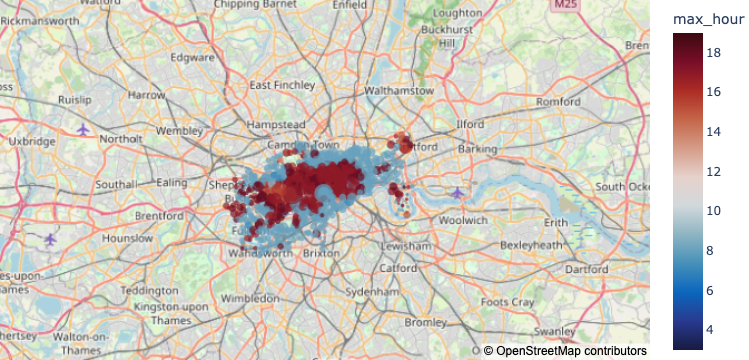

In [14]:
%%local
import plotly
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter_mapbox(df, lat=df.lat.astype('float'), lon=df.lon.astype('float'), hover_name="Name", hover_data=[ "counts"],
                        size = 'counts',color_continuous_scale=px.colors.diverging.balance, color = 'max_hour',size_max=15, zoom=10.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0.5,"t":0,"l":0,"b":0})

fig.show()

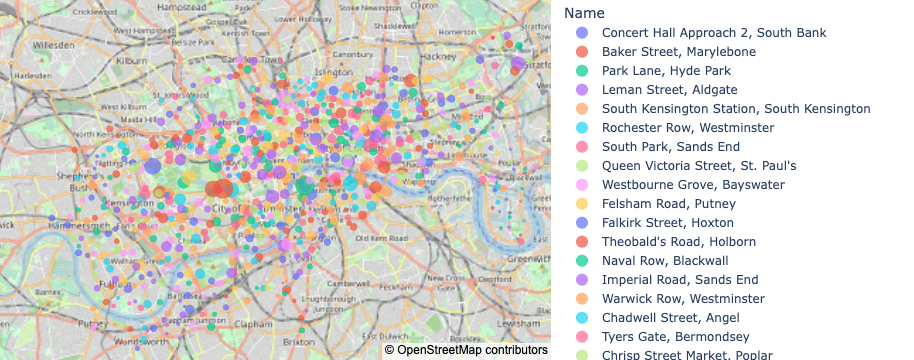

In [15]:
%%local
import plotly
import plotly.graph_objects as go
import plotly.express as px

fig = px.scatter_mapbox(df, lat=df.lat.astype('float'), lon=df.lon.astype('float'), hover_name="Name", hover_data=["Name", "counts"],
                        size = 'counts',color_continuous_scale=px.colors.diverging.balance, color = 'Name',size_max=15, zoom=10.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0.5,"t":0,"l":0,"b":0})

fig.show()

In [16]:
### endstation
end_pair = data_tidy.map(lambda x:(x[4].replace('.0',''),get_hour(x[3])))
end_loc = end_pair.join(map_pair)
end_loc.cache()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PythonRDD[60] at RDD at PythonRDD.scala:53

In [17]:
end_loc_count = end_loc.map(lambda x: (x[0],x[1][1][0],x[1][1][1],x[1][1][2])).countByValue()
end_loc_time = end_loc.map(lambda x: (x[0],x[1][0],x[1][1][0],x[1][1][1],x[1][1][2])).countByValue()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
dfff = [(list(k)+[v]) for k,v in end_loc_count.items()]
df_end = pd.DataFrame(a,columns=['id','Name','lon','lat','counts'])
time_end = [(list(k)+[v]) for k,v in end_loc_time.items()]

id_max_time ={}
for line in time_end:
    if line[0] not in id_max_time.keys() or id_max_time[line[0]][1]<line[-1]:
        id_max_time[line[0]]=(line[1],line[-1])

def get_max_hour(col):
    return id_max_time[col][0]

df_end['max_hour'] = df_end['id'].apply(lambda x: get_max_hour(x))

sparkDF_end = spark.createDataFrame(df_end) 
sparkDF_end.createOrReplaceTempView("end_view")



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
%%sql -o df_end
SELECT * FROM end_view

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Output()

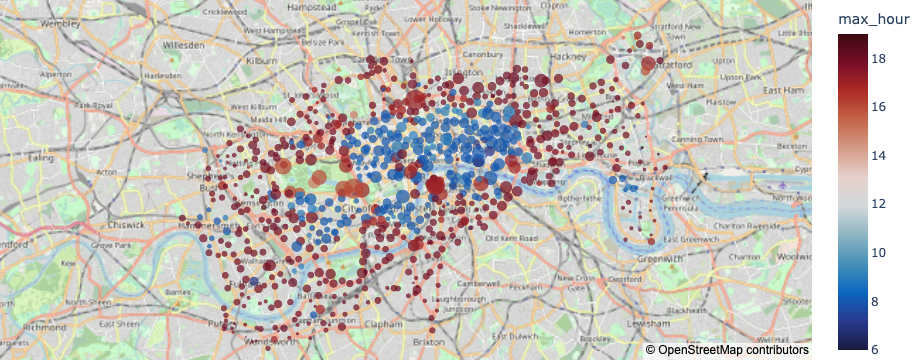

In [20]:
%%local
fig = px.scatter_mapbox(df_end, 
                        lat=df_end.lat.astype('float'), 
                        lon=df_end.lon.astype('float'), 
                        hover_name="Name", 
                        hover_data=["Name", "counts"],
                        size = 'counts',
                        color_continuous_scale=px.colors.diverging.balance, 
                        color = 'max_hour',size_max=15, zoom=10.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0.5,"t":0,"l":0,"b":0})

fig.show()

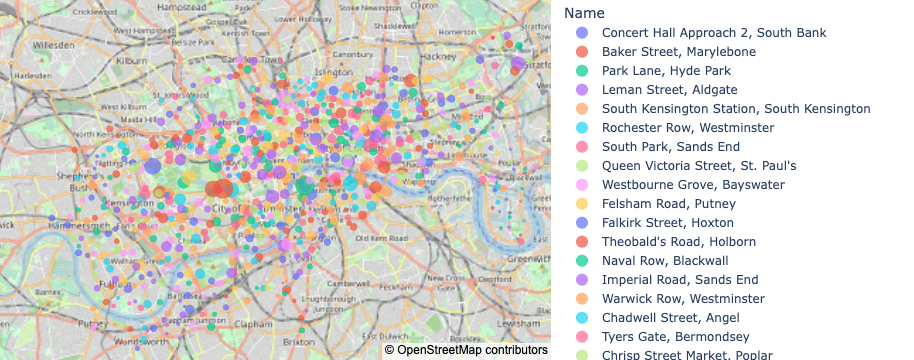

In [21]:
%%local
fig = px.scatter_mapbox(df_end, 
                        lat=df_end.lat.astype('float'), 
                        lon=df_end.lon.astype('float'), 
                        hover_name="counts", 
                        hover_data=["Name", "counts"],
                        size = 'counts',
                        color_continuous_scale=px.colors.diverging.balance, 
                        color = 'Name',size_max=15, zoom=10.5)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0.5,"t":0,"l":0,"b":0})

fig.show()

In [22]:
endtime = time.time()
endtime- startime

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

699.091676235199